In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def house_values_from_zillow(year):
  zillow_data = pd.read_csv("/content/drive/MyDrive/Citadel Women's Datathon/Women's 2025 Datathon Datasets/Zillow Data.csv")

  # keeping rows from January
  filtered_df = zillow_data[zillow_data['date'].str.startswith(f'{year}-01-')]

  # drop null and duplicates
  filtered_df = filtered_df.dropna(subset=['Metro'])
  filtered_df = filtered_df.drop_duplicates(subset=['zip_code'])

  # drop entries without states in the metro area
  filtered_df = filtered_df[filtered_df['Metro'].str.contains(",")]
  filtered_df = filtered_df[['median_estimated_home_values', 'zip_code','Metro']]
  return filtered_df

In [27]:
zillow_2013 = house_values_from_zillow(2013)
zillow_2023 = house_values_from_zillow(2023)

In [32]:
# merge dfs on zip code
merged_df = pd.merge(zillow_2013, zillow_2023, on='zip_code', suffixes=('_13', '_23'))

# new col for house value difference
house_val_23 = merged_df['median_estimated_home_values_23']
house_val_13 = merged_df['median_estimated_home_values_13']
merged_df['house_value_diff'] = house_val_23 - house_val_13
merged_df['house_value_per_change'] = (house_val_23 - house_val_13) / house_val_13 * 100.0

print(merged_df[['zip_code', 'house_value_diff', 'house_value_per_change']])


       zip_code  house_value_diff  house_value_per_change
0       99623.0     117243.272906               58.908987
1       99901.0     154622.486243               61.779670
2       99824.0      57014.899340               20.612145
3       99801.0     138526.524994               40.462782
4       99714.0      51683.836182               32.337399
...         ...               ...                     ...
18081   82054.0     187825.308839               75.545143
18082   82053.0     169945.553386               80.521206
18083   82009.0     178208.471349               62.886519
18084   82007.0     125645.300170               75.254680
18085   82001.0     137851.839283               75.310461

[18086 rows x 3 columns]


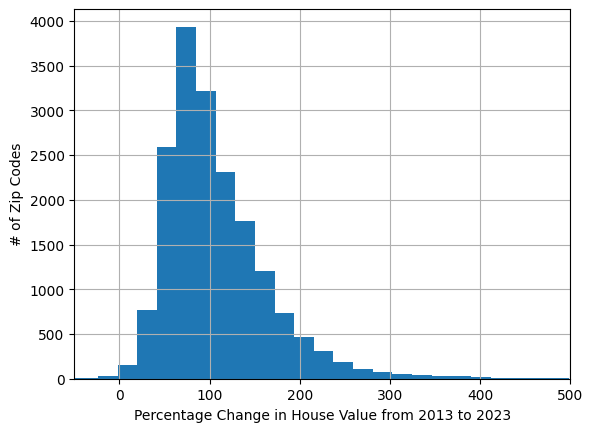

<Figure size 640x480 with 0 Axes>

In [50]:
merged_df['house_value_per_change'].hist(bins=55)
plt.xlim(-50, 500)
plt.xlabel("Percentage Change in House Value from 2013 to 2023")
plt.ylabel("# of Zip Codes")
plt.figure()
plt.show()

In [91]:
g_data = pd.read_csv("/content/drive/MyDrive/Citadel Women's Datathon/Women's 2025 Datathon Datasets/red-blue.csv")
print(g_data[:5])
merged_g = merged_df.merge(g_data, left_on='zip_code', right_on='GEO_ID')
merged_g['ratio'] = g_data['ratio_2023'] - g_data['ratio_2013']
valid_data = merged_g[['ratio', 'house_value_per_change']].dropna()

correlation = valid_data['ratio'].corr(valid_data['house_value_per_change'])
print(len(merged_g['house_value_per_change']))
print(len(merged_g['ratio']))
print(correlation)

   GEO_ID  ratio_2013  ratio_2023 color_group  color_flag
0    1009    1.045126    0.933365      Normal           0
1    1029    1.042942    1.000000      Normal           0
2    1350    0.781531    1.444640      Normal           0
3    2534    1.000000    1.000000      Normal           0
4    4024    0.954047    0.850995      Normal           0
14335
14335
-0.0032437495335636986


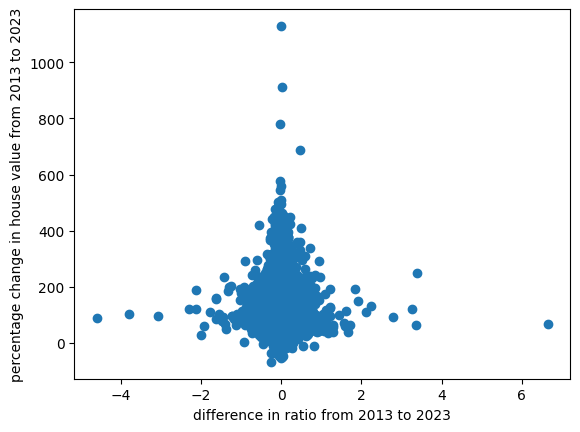

In [70]:
plt.figure()
plt.scatter(merged_g['ratio'], merged_g['house_value_per_change'])
plt.xlabel('difference in ratio from 2013 to 2023')
plt.ylabel('percentage change in house value from 2013 to 2023')
plt.show()

In [94]:
#get all zip codes where color flag = 0
#get all zip codes where color flag = 1
#graph change in house prices for each of these, also find average percentage change in house value
house_value_change_0 = merged_g[merged_g['color_flag'] == 0]['house_value_per_change']
house_value_change_1 = merged_g[merged_g['color_flag'] == 1]['house_value_per_change']
mean_0 = house_value_change_0.mean()
mean_1 = house_value_change_1.mean()
mean_total = merged_g['house_value_per_change'].mean()
print("mean percentage change in median house value for all houses: ", mean_total)
print("mean percentage change in median house value for not gentrified: ", mean_0)
print("mean percentage change in median house value for gentrified: ", mean_1)

mean percentage change in median house value for all houses:  112.5516143917186
mean percentage change in median house value for not gentrified:  111.33950422040996
mean percentage change in median house value for gentrified:  151.65411977890042


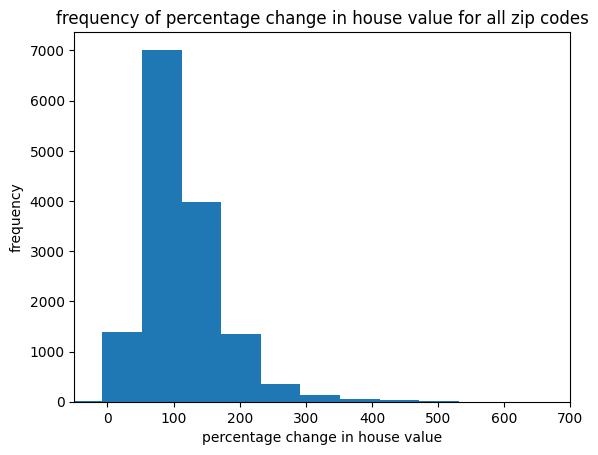

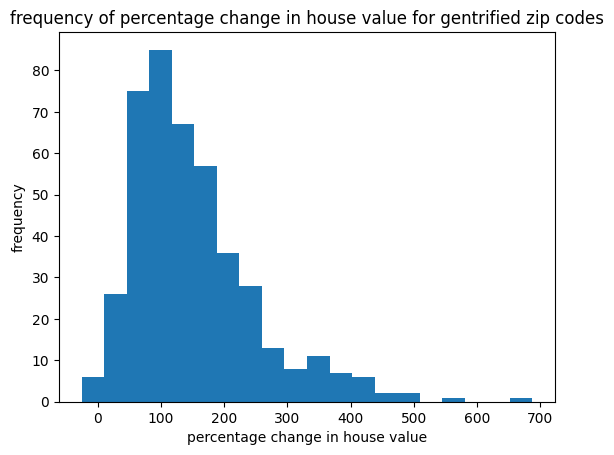

In [79]:
plt.figure()
plt.hist(merged_g['house_value_per_change'], bins=20)
plt.xlim(-50, 700)
plt.title('frequency of percentage change in house value for all zip codes')
plt.xlabel('percentage change in house value')
plt.ylabel('frequency')
plt.show()
plt.figure()
plt.hist(house_value_change_1, bins=20)
plt.title('frequency of percentage change in house value for gentrified zip codes')
plt.xlabel('percentage change in house value')
plt.ylabel('frequency')
plt.show()

In [82]:
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
X = merged_g[['house_value_per_change']]
y = merged_g['color_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9746570564984888
Confusion Matrix:
 [[4192    0]
 [ 109    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      4192
           1       0.00      0.00      0.00       109

    accuracy                           0.97      4301
   macro avg       0.49      0.50      0.49      4301
weighted avg       0.95      0.97      0.96      4301



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [97]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from scipy import stats
stat, p_value = shapiro(merged_g['house_value_per_change'])
print(f"Shapiro-Wilk test: stat={stat}, p-value={p_value}")

stat, p_value = mannwhitneyu(house_value_change_1, merged_g['house_value_per_change'])
print(f"U-statistic: {stat}, p-value: {p_value}")

Shapiro-Wilk test: stat=0.8783668091451114, p-value=7.569833866666058e-74
U-statistic: 3816426.5, p-value: 7.41118508297162e-17


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14335.
  res = hypotest_fun_out(*samples, **kwds)


In [109]:
race_data = g_data = pd.read_csv("/content/drive/MyDrive/Citadel Women's Datathon/Women's 2025 Datathon Datasets/racedata.csv")
merged_race = merged_g.merge(race_data, left_on='zip_code', right_on='GEO_ID')
print(len(merged_race))
#print(merged_race[:5])
only_african_american = merged_race['estimate_race_one_race_black_or_african_american']
percent_change = merged_race['house_value_per_change']
labels = merged_race['color_flag_x']

X = pd.DataFrame({'only_african_american': only_african_american, 'percent_change': percent_change})
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

coefficients = model.coef_[0]
for feature, coef in zip(X.columns, coefficients):
    print(f"Coefficient for {feature}: {coef}")


319
Accuracy: 0.9895833333333334
Confusion Matrix:
 [[94  0]
 [ 1  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        94
           1       1.00      0.50      0.67         2

    accuracy                           0.99        96
   macro avg       0.99      0.75      0.83        96
weighted avg       0.99      0.99      0.99        96

Coefficient for only_african_american: 1.742090095831822e-06
Coefficient for percent_change: 0.009362169985244622
